# Covid-19: From model prediction to model predictive control

## Calibration of the age-stratified deterministic model (1)

*Original code by Ryan S. McGee. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

This notebook was made to quickly perform scenario analysis with the age-stratified model implementation.

### Load required packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from ipywidgets import interact,fixed,FloatSlider,IntSlider,ToggleButtons
import pandas as pd
import datetime
import scipy
from scipy.integrate import odeint
import matplotlib.dates as mdates
import matplotlib
import scipy.stats as st
import networkx # to install networkx in your environment: conda install networkx
from covid19model.models import models
from covid19model.data import google
from covid19model.data import sciensano
from covid19model.data import polymod
from covid19model.data import parameters
from covid19model.visualization.output import population_status, infected
from covid19model.visualization.optimization import plot_fit, traceplot
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2
import math
import xarray as xr
import emcee
from covid19model.optimization import objective_fcns
from covid19model.optimization import MCMC

### Load interaction matrices

In [2]:
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = polymod.get_interaction_matrices()
levels = initN.size

In [3]:
params = parameters.get_COVID19_SEIRD_parameters()
params.update({'l': 7,
               'tau': 1})
initial_states = {'S': initN, 'E': np.ones(levels)}
from covid19model.models.compliance import ramp_2
model = models.COVID19_SEIRD(initial_states, params, compliance=ramp_2)

### Scrape high-level Sciensano data

In [4]:
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)
df_sciensano.head()

,H_tot,ICU_tot,H_in,H_out,H_tot_cumsum,D_tot,D_25_44,D_45_64,D_65_74,D_75_84,D_85+
DATE,,,,,,,,,,,
2020-03-15,266,54,71,18,53,6,0.0,0.0,3.0,1,2
2020-03-16,370,79,90,14,129,11,0.0,0.0,3.0,3,5
2020-03-17,497,100,122,31,220,12,0.0,0.0,1.0,4,7
2020-03-18,650,131,179,48,351,22,1.0,1.0,2.0,6,10
2020-03-19,844,165,207,49,509,28,0.0,0.0,8.0,5,14


### Calibrating $\beta$ and lag_time

**Skip this section when parameters were previously calibrated**

Use the function fit_pso to obtain a good first estimate for the MCMC sampler.

In [7]:
# define dataset
data=[df_sciensano["H_in"].values[:9]]
# set optimisation settings
parNames = ['sigma_H_in','extraTime','beta'] # must be a list!
states = [["H_in"]]
bounds=((1,50),(30,55),(0.02,0.06)) # must be a list!
# run optimisation
theta = MCMC.fit_pso(model,data,parNames,states,bounds,maxiter=50,popsize=50)

No constraints given.
Best after iteration 1: [42.72894514 32.1255875   0.05884456] 49.829128282075885
Best after iteration 2: [42.72894514 32.1255875   0.05884456] 49.829128282075885
New best for swarm at iteration 3: [46.0639374  36.09915059  0.05263383] 46.07988607238845
Best after iteration 3: [46.0639374  36.09915059  0.05263383] 46.07988607238845
Best after iteration 4: [46.0639374  36.09915059  0.05263383] 46.07988607238845
Best after iteration 5: [46.0639374  36.09915059  0.05263383] 46.07988607238845
New best for swarm at iteration 6: [50.         35.97342089  0.05267083] 45.168261981141924
Best after iteration 6: [50.         35.97342089  0.05267083] 45.168261981141924
New best for swarm at iteration 7: [4.71031747e+01 4.16592440e+01 4.45468343e-02] 42.736805297981235
Best after iteration 7: [4.71031747e+01 4.16592440e+01 4.45468343e-02] 42.736805297981235
New best for swarm at iteration 8: [4.53079099e+01 4.49777056e+01 4.21425068e-02] 41.47275889929953
Best after iteration 

In [8]:
lag_time = int(round(theta[1]))
model.extraTime = int(round(theta[1]))

model.parameters.update({
    'beta': theta[2],
}
)

start_date = '15-03-2020'

Initiatize and run the MCMC sampler

In [10]:
parNames = ['sigma_ICU','beta'] # must be a list!
bounds=((1,200),(0.01,0.10))

pos = [theta[0],theta[2]] + [1, 1e-2 ]* np.random.randn(4, 2)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds,data,states,parNames))
sampler.run_mcmc(pos, 10000, progress=True);

100%|██████████| 10000/10000 [21:03<00:00,  7.91it/s]


In [11]:
samples = sampler.get_chain(discard=200,flat=False)
flat_samples = sampler.get_chain(discard=200,flat=True)

In [12]:
sampler.get_autocorr_time()

array([51.94170228, 43.29918064])

In [11]:
mean = np.mean(flat_samples[:,1])
p10 = np.percentile(flat_samples[:,1],10)
p90 = np.percentile(flat_samples[:,1],90)
print(mean,p10,p90)

0.037688389837820795 0.037483043296351846 0.03788686979236626


Initialize a dictionary of samples and write them to `parameters.json`

In [13]:
samples_dict={'lag_time': int(round(theta[1])), 'beta': flat_samples[:,1].tolist()}

In [14]:
import json

with open('parameters_deterministic.json', 'w') as fp:
    json.dump(samples_dict, fp)

Make some diagnostic visualisations

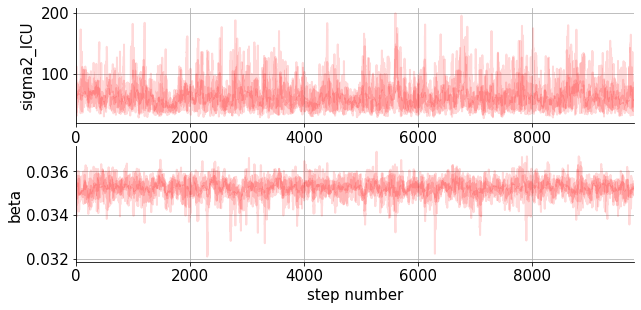

In [15]:
traceplot(samples,labels=["sigma2_ICU","beta"],plt_kwargs={'linewidth':2,'color': 'red','alpha': 0.15})

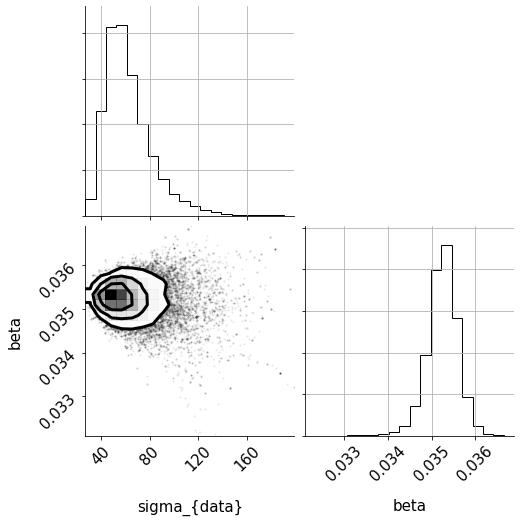

In [16]:
import corner

fig = corner.corner(
    flat_samples,labels=['sigma_{data}','beta']
);
fig.set_size_inches(8, 8)
plt.savefig('corner.pdf', dpi=600, bbox_inches='tight',
                    orientation='portrait', papertype='a4')

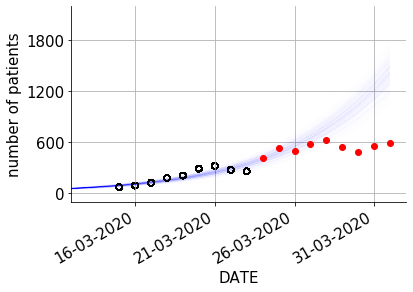

In [41]:
T = 9
fig,ax=plt.subplots()
for i in range(400):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    y_model = model.sim(data[0].size+lag_time-1+T)
    ax = plot_fit(y_model,data,start_date,lag_time,states,T=T,ax=ax,plt_kwargs={'color':'blue','linewidth': 0.05,'alpha': 0.05})

df_sciensano["H_in"][9:18].plot(marker='o',color='red',linestyle='None')
plt.savefig('plot_fit_beta.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

### Calibrating the compliance function parameter l

#### Loading $\beta$ and lag_time

Load the previously calibrated parameters.

In [5]:
import json
with open('parameters_deterministic.json', 'r') as fp:
    samples_dict = json.load(fp)

lag_time = samples_dict['lag_time']
model.extraTime = samples_dict['lag_time']
model.parameters['beta'] = np.mean(samples_dict['beta'])

In [6]:
samples_beta = {'beta': samples_dict['beta']}

#### Initial guess for MCMC with PSO

In [7]:
# Create checkpoints dictionary
chk = {'time':  [lag_time], 
       'Nc':    [0.2*Nc_home + ((1-0.70)*Nc_work + (1-0.80)*Nc_transport)],
      }
# checkpoints are hardcoded!

# define dataset
data=[df_sciensano["H_in"].values[:37]]
# set optimisation settings
parNames = ['sigma_H_in','l','tau','prevention'] # must be a list!
states = [["H_in"]]
bounds=((1,100),(1,20),(1,20),(0.01,1)) # must be a list!
# run optimisation
theta = MCMC.fit_pso(model,data,parNames,states,bounds,checkpoints=chk,samples=samples_beta,maxiter=100,popsize=50)

No constraints given.
New best for swarm at iteration 1: [100.           1.40815898   7.39715331   0.15601207] 180.0916238390721
Best after iteration 1: [100.           1.40815898   7.39715331   0.15601207] 180.0916238390721
Best after iteration 2: [100.           1.40815898   7.39715331   0.15601207] 180.0916238390721
Best after iteration 3: [100.           1.40815898   7.39715331   0.15601207] 180.0916238390721
New best for swarm at iteration 4: [100.           1.           6.66671856   0.21183716] 177.83320200484863
Best after iteration 4: [100.           1.           6.66671856   0.21183716] 177.83320200484863
New best for swarm at iteration 5: [100.           1.           6.93287236   0.24017556] 176.24566998219274
Best after iteration 5: [100.           1.           6.93287236   0.24017556] 176.24566998219274
Best after iteration 6: [100.           1.           6.93287236   0.24017556] 176.24566998219274
Best after iteration 7: [100.           1.           6.93287236   0.24017556

Best after iteration 63: [95.52092125  1.97289426  5.84489976  0.27452235] 174.86683550967476
New best for swarm at iteration 64: [94.69867637  1.89423909  5.86727175  0.27835738] 174.75070799351593
Best after iteration 64: [94.69867637  1.89423909  5.86727175  0.27835738] 174.75070799351593
New best for swarm at iteration 65: [94.13975312  1.85554389  5.84945778  0.27806442] 174.53031712356284
Best after iteration 65: [94.13975312  1.85554389  5.84945778  0.27806442] 174.53031712356284
New best for swarm at iteration 66: [93.61702691  1.85337366  5.74365069  0.27894156] 174.40856216066194
Best after iteration 66: [93.61702691  1.85337366  5.74365069  0.27894156] 174.40856216066194
New best for swarm at iteration 67: [93.24144625  1.83105456  5.70632477  0.27904249] 174.32323203759617
Best after iteration 67: [93.24144625  1.83105456  5.70632477  0.27904249] 174.32323203759617
Best after iteration 68: [93.24144625  1.83105456  5.70632477  0.27904249] 174.32323203759617
New best for swa

In [8]:
model.parameters.update({
    'l': theta[1],
    'tau': theta[2]
}
)
prevention = theta[3]
# Create checkpoints dictionary
chk = {'time':  [lag_time], 
       'Nc':    [prevention*(1.3*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure)],
      }

In [12]:
bounds=((1,100),(0.1,20),(0.1,20),(0.01,1)) # must be a list!
pos = theta + [1, 1, 1, 1e-1 ]* np.random.randn(8, 4)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds,data,states,parNames,chk,samples_beta))
sampler.run_mcmc(pos, 2000, progress=True);

  0%|          | 0/2000 [00:00<?, ?it/s]/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 2000/2000 [13:25<00:00,  2.48it/s]


In [13]:
sampler.get_autocorr_time()

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 40;
tau: [114.07915542 104.79707178 109.17436535  74.68732132]

In [14]:
samples = sampler.get_chain(discard=100,flat=False)
flat_samples = sampler.get_chain(discard=100,flat=True)

In [37]:
samples_dict.update({'l': flat_samples[:,1].tolist(),'tau':flat_samples[:,2].tolist(),'prevention':flat_samples[:,3].tolist()})

In [38]:
import json

with open('parameters_deterministic.json', 'w') as fp:
    json.dump(samples_dict, fp)

In [18]:
mean = np.mean(flat_samples[:,2])
p10 = np.percentile(flat_samples[:,2],10)
p90 = np.percentile(flat_samples[:,2],90)
print(mean,p10,p90)

0.6349150380542461 0.4942712390265831 0.7622050805358451


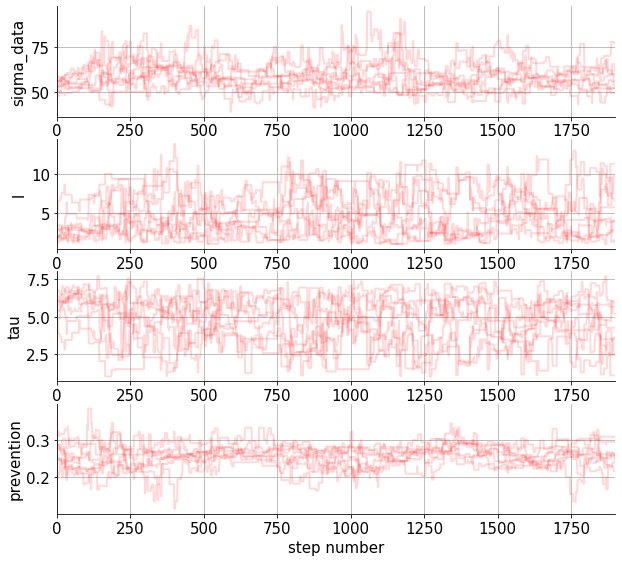

In [34]:
traceplot(samples=sampler.get_chain(discard=100),labels=["sigma_data","l","tau","prevention"],plt_kwargs={'linewidth':2,'color': 'red','alpha': 0.15})

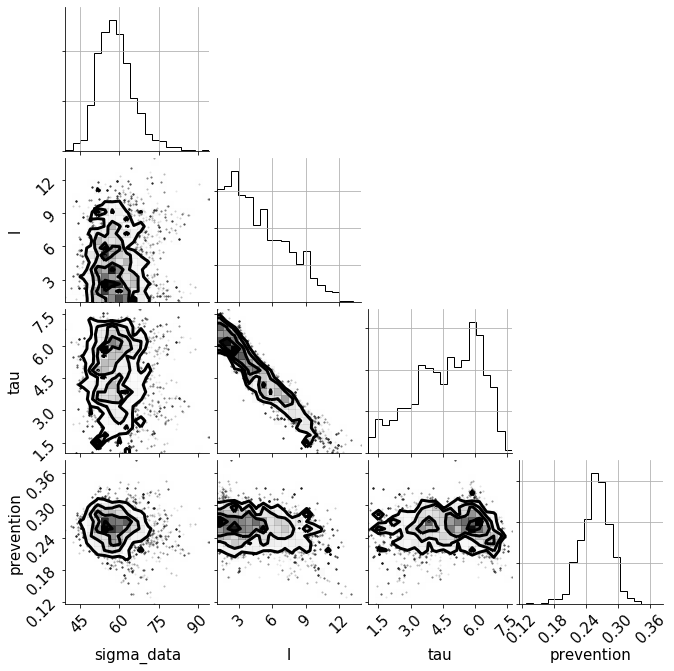

In [35]:
import corner

fig = corner.corner(
    flat_samples, labels=["sigma_data","l","tau","prevention"],
);

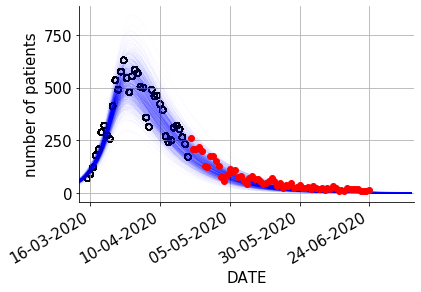

In [31]:
import random
T = 80
start_date = '15-03-2020'
fig,ax=plt.subplots()
for i in range(1000):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    prevention = np.random.choice(samples_dict['prevention'],1,replace=False)
    # Create checkpoints dictionary
    chk = {'time':  [lag_time], 
           'Nc':    [prevention*(1.3*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure)],
          }
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    ax = plot_fit(y_model,data,start_date,lag_time,states,T=T,ax=ax,plt_kwargs={'color':'blue','linewidth': 0.25,'alpha': 0.05})

df_sciensano["H_in"][37:].plot(marker='o',color='red',linestyle='None')
plt.savefig('plot_fit_compliance.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

### Calibration of hospitalization parameters

Load the previously calibrated parameters: $\beta$, lag_time, k, t0, prevention

In [6]:
import json
with open('parameters_deterministic.json', 'r') as fp:
    samples_dict = json.load(fp)

lag_time = samples_dict['lag_time']
model.extraTime = samples_dict['lag_time']
model.parameters['beta'] = np.mean(samples_dict['beta'])
model.parameters['l'] = np.mean(samples_dict['l'])
model.parameters['tau'] = np.mean(samples_dict['tau'])
prevention = np.mean(samples_dict['prevention'])

In [11]:
# Create checkpoints dictionary
chk = {'time':  [lag_time], 
       'Nc':    [prevention*(1.3*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure)],
      }

model.parameters['dICUrec'] = 12

# define dataset
data=[df_sciensano["H_out"].values[:55],df_sciensano["ICU_tot"].values[:55],df_sciensano["H_tot"].values[:55]]
# set optimisation settings
parNames = ['sigma_H_out','sigma_ICU_tot','sigma_H_tot','dc','dICU'] # must be a list!
states = [["H_out"],["ICU"],["H_tot"]]
bounds=((1,200),(1,300),(1,600),(2,30),(2,20)) # must be a list!
# run optimisation
theta = MCMC.fit_pso(model,data,parNames,states,bounds,checkpoints=chk,maxiter=100,popsize=50)

No constraints given.
Best after iteration 1: [118.84793701 289.46604795 590.74386693  12.86627252   7.12483283] 974.3356898713955
Best after iteration 2: [118.84793701 289.46604795 590.74386693  12.86627252   7.12483283] 974.3356898713955
New best for swarm at iteration 3: [ 97.19322328 285.72815934 458.50637458  14.77015322   8.34668591] 946.9712712708449
Best after iteration 3: [ 97.19322328 285.72815934 458.50637458  14.77015322   8.34668591] 946.9712712708449
New best for swarm at iteration 4: [ 99.91110284  87.02952104 483.8959755   18.44736483   9.03404271] 931.0944355036548
Best after iteration 4: [ 99.91110284  87.02952104 483.8959755   18.44736483   9.03404271] 931.0944355036548
Best after iteration 5: [ 99.91110284  87.02952104 483.8959755   18.44736483   9.03404271] 931.0944355036548
New best for swarm at iteration 6: [100.27200384 108.57052822 492.07101171  13.57414251   8.6999406 ] 908.5685849259859
Best after iteration 6: [100.27200384 108.57052822 492.07101171  13.57414

New best for swarm at iteration 46: [106.19190399  75.23998798 296.73758784  14.44788753   8.90159914] 889.894822394883
Best after iteration 46: [106.19190399  75.23998798 296.73758784  14.44788753   8.90159914] 889.894822394883
New best for swarm at iteration 47: [106.23621966  75.41420128 297.04311902  14.42381114   8.89562152] 889.8947829573174
Best after iteration 47: [106.23621966  75.41420128 297.04311902  14.42381114   8.89562152] 889.8947829573174
Best after iteration 48: [106.23621966  75.41420128 297.04311902  14.42381114   8.89562152] 889.8947829573174
New best for swarm at iteration 49: [106.49723104  75.40158442 296.53331705  14.43130358   8.89584527] 889.892053452603
Best after iteration 49: [106.49723104  75.40158442 296.53331705  14.43130358   8.89584527] 889.892053452603
Best after iteration 50: [106.49723104  75.40158442 296.53331705  14.43130358   8.89584527] 889.892053452603
Best after iteration 51: [106.49723104  75.40158442 296.53331705  14.43130358   8.89584527] 

In [12]:
model.parameters.update({
    'dc': theta[3],
    'dICU': theta[4]
}
)

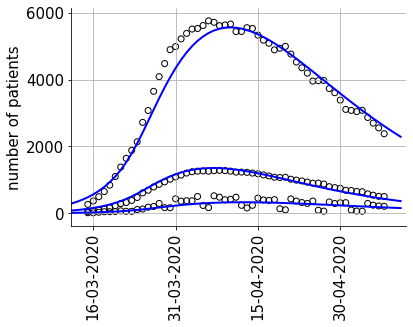

In [13]:
T = 3
fig,ax=plt.subplots()
for i in range(1):
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    ax = plot_fit(y_model,data,'15-03-2020',lag_time,states,T=T,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 1})

In [14]:
pos = theta + [5,5,5,3,3]* np.random.randn(10, 5)
bounds=((1,300),(1,400),(1,800),(1,30),(1,30)) 
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds,data,states,parNames,chk))
sampler.run_mcmc(pos, 1000, progress=True);

  0%|          | 0/1000 [00:00<?, ?it/s]/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1000/1000 [11:01<00:00,  1.51it/s]


In [15]:
sampler.get_autocorr_time()

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [48.72758607 36.45325089 37.15449402 28.67515652 27.63761053]

In [16]:
samples = sampler.get_chain(discard=50,flat=False)
flat_samples = sampler.get_chain(discard=50,flat=True)

In [27]:
mean = np.mean(samples_dict['dICU'])
p10 = np.percentile(samples_dict['dICU'],10)
p90 = np.percentile(samples_dict['dICU'],90)
print(mean,p10,p90)

KeyError: 'dICU'

In [21]:
samples_dict.update({'dc': flat_samples[:,3].tolist(), 'dICU': flat_samples[:,4].tolist()})

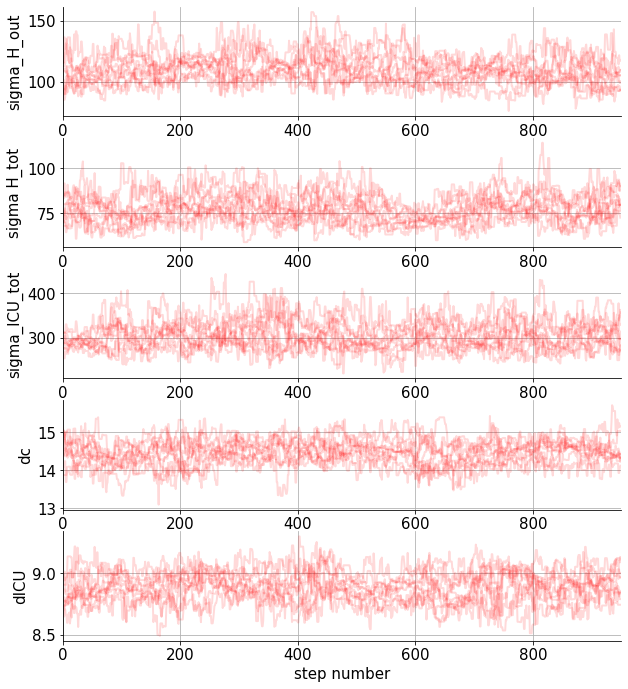

In [17]:
traceplot(samples=sampler.get_chain(discard=50),labels=["sigma_H_out","sigma H_tot","sigma_ICU_tot","dc","dICU"],plt_kwargs={'linewidth':2,'color': 'red','alpha': 0.15})

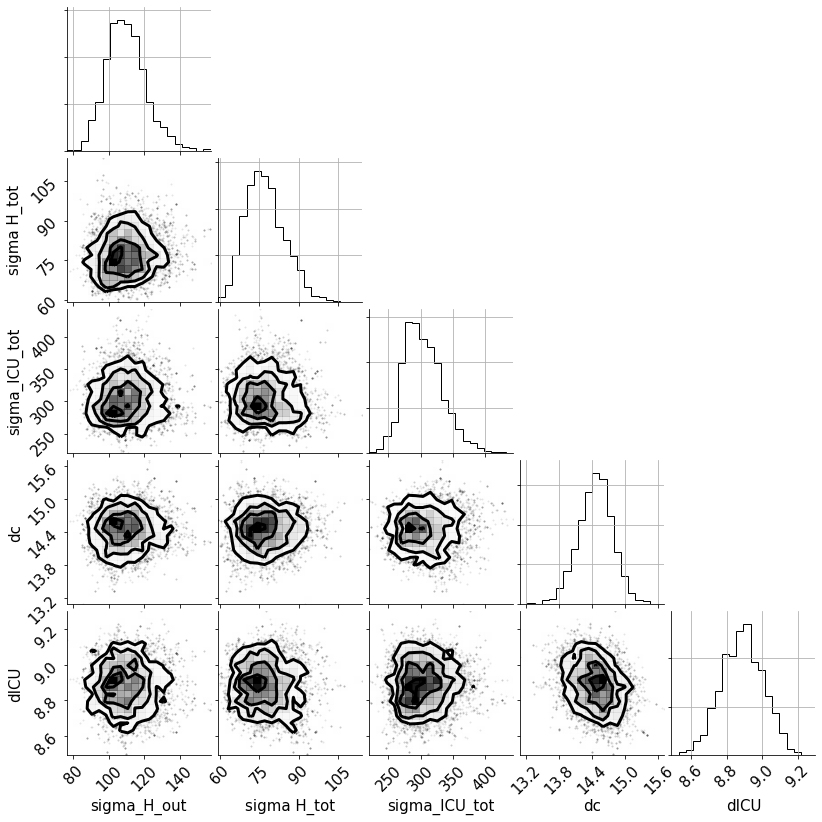

In [18]:
import corner

fig = corner.corner(
    flat_samples, labels=["sigma_H_out","sigma H_tot","sigma_ICU_tot","dc","dICU"],
);

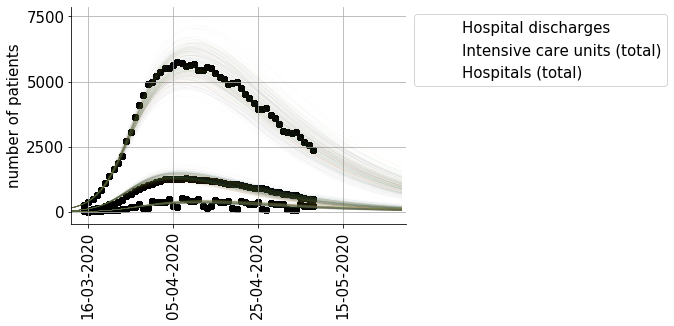

In [35]:
T = 21

fig,ax=plt.subplots()
for i in range(300):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    model.parameters['l'] = np.random.choice(samples_dict['l'],1,replace=False)
    prevention = np.random.choice(samples_dict['prevention'],1,replace=False)
    model.parameters['dc'] = np.random.choice(samples_dict['dc'],1,replace=False)
    model.parameters['dICU'] = np.random.choice(samples_dict['dICU'],1,replace=False)
    # Create checkpoints dictionary
    chk = {'time':  [lag_time], 
           'Nc':    [prevention*(1.3*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure)],
      }
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    ax = plot_fit(y_model,data,'15-03-2020',lag_time,states,T=T,ax=ax,
                  legend_text=['Hospital discharges','Intensive care units (total)','Hospitals (total)'],
                  plt_kwargs={'linewidth': 0.10,'alpha': 0.15})

In [22]:
import json

with open('parameters_deterministic.json', 'w') as fp:
    json.dump(samples_dict, fp)

# Notebook works till here

### Scenarios

In [23]:
import json
with open('parameters_deterministic.json', 'r') as fp:
    samples_dict = json.load(fp)

lag_time = samples_dict['lag_time']
model.extraTime = samples_dict['lag_time']
model.parameters['beta'] = np.mean(samples_dict['beta'])
model.parameters['l'] = np.mean(samples_dict['l'])
prevention = np.mean(samples_dict['prevention'])
model.parameters['dc'] = np.mean(samples_dict['dc'])
model.parameters['dICU'] = np.mean(samples_dict['dICU'])

In [24]:
data=[df_sciensano["H_tot"].values[:],df_sciensano["ICU_tot"].values[:]]
states = [["H_tot"],["ICU"]]

In [7]:
# Define data as a list containing data timeseries
index = pd.date_range('15-03-2020',freq='D',periods=data[0].size + lag_time + T)
print(index[1],index[50],index[52],index[57],index[64],index[81],index[108],index[170])

NameError: name 'T' is not defined

In [26]:
import random

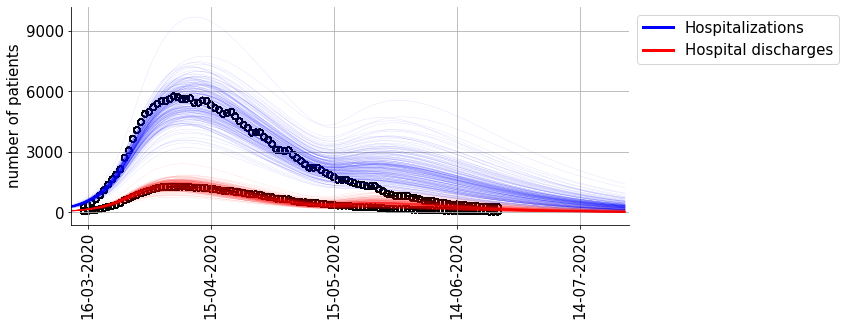

In [31]:
T = 31

fig,ax=plt.subplots()
for i in range(200):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    prevention = np.random.choice(samples_dict['prevention'],1,replace=False)
    model.parameters['dc'] = np.random.choice(samples_dict['dc'],1,replace=False)
    model.parameters['dICU'] = np.random.choice(samples_dict['dICU'],1,replace=False)
    # Create a dictionary of past policies
    chk = {'time':   [lag_time,lag_time+50,lag_time+52], 
          'Nc':      [prevention*(1.3*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure),
                      prevention*(1.25*Nc_home + (1-0.50)*Nc_work + (1-0.60)*Nc_transport + (1-0.30)*Nc_others + (1-0.70)*Nc_leisure),
                      prevention*(1.20*Nc_home + (1-0.40)*Nc_work + (1-0.55)*Nc_transport + (1-0.25)*Nc_others + (1-0.65)*Nc_leisure),]
                      #prevention*(1.15*Nc_home + (1-0.30)*Nc_work + (1-0.50)*Nc_transport + (1-0.20)*Nc_others + (1-0.60)*Nc_leisure),
                      #prevention*(1.10*Nc_home + (1-0.30)*Nc_work + (1-0.45)*Nc_transport + (1-0.85)*Nc_schools + (1-0.15)*Nc_others + (1-0.50)*Nc_leisure),
                      #prevention*(Nc_home + (1-0.25)*Nc_work + (1-0.35)*Nc_transport + (1-0.35)*Nc_schools + (1-0.10)*Nc_others + (1-0.30)*Nc_leisure),]
                              #0.2*Nc_home + prevention*((1-0.20)*Nc_work + (1-0.15)*Nc_transport + (1-0.00)*Nc_others + (1-0.00)*Nc_leisure)]
                  }
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    ax = plot_fit(y_model,data,'15-03-2020',lag_time,states,T=T,ax=ax,
                  legend_text=None,
                  plt_kwargs={'linewidth': 0.25,'alpha': 0.20})

legend_text=['Hospitalizations','Hospital discharges']
leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
for lh in leg.get_lines(): 
    lh.set_alpha(1)
fig.set_size_inches(10, 4)
plt.savefig('scenarios_future.pdf', dpi=300, bbox_inches='tight',orientation='portrait', papertype='a4')
plt.savefig('scenarios_future.svg', dpi=300, bbox_inches='tight',orientation='portrait', papertype='a4')

Text(0, 0.5, "fraction 'immune'")

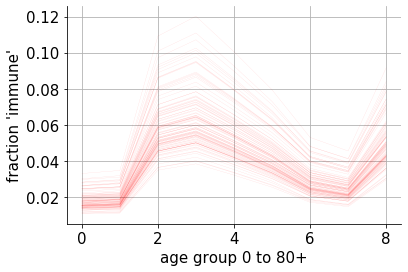

In [30]:
fig,ax=plt.subplots()
for i in range(100):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    model.parameters['l'] = np.random.choice(samples_dict['l'],1,replace=False)
    prevention = np.random.choice(samples_dict['prevention'],1,replace=False)
    model.parameters['dc'] = np.random.choice(samples_dict['dc'],1,replace=False)
    model.parameters['dICU'] = np.random.choice(samples_dict['dICU'],1,replace=False)
    # Create a dictionary of past policies
    chk = {'time':   [lag_time,lag_time+50,lag_time+52,lag_time+57], 
          'Nc':      [prevention*(1.3*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure),
                      prevention*(1.2*Nc_home + (1-0.50)*Nc_work + (1-0.60)*Nc_transport + (1-0.30)*Nc_others + (1-0.70)*Nc_leisure),
                      prevention*(1.1*Nc_home + (1-0.40)*Nc_work + (1-0.55)*Nc_transport + (1-0.25)*Nc_others + (1-0.65)*Nc_leisure),
                      prevention*(Nc_home + (1-0.30)*Nc_work + (1-0.50)*Nc_transport + (1-0.20)*Nc_others + (1-0.60)*Nc_leisure),]
                              #0.2*Nc_home + prevention*((1-0.30)*Nc_work + (1-0.45)*Nc_transport + (1-0.85)*Nc_schools + (1-0.15)*Nc_others + (1-0.50)*Nc_leisure),
                              #0.2*Nc_home + prevention*((1-0.25)*Nc_work + (1-0.35)*Nc_transport + (1-0.35)*Nc_schools + (1-0.10)*Nc_others + (1-0.30)*Nc_leisure),
                              #0.2*Nc_home + prevention*((1-0.20)*Nc_work + (1-0.15)*Nc_transport + (1-0.00)*Nc_others + (1-0.00)*Nc_leisure)]
                  }
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    #ax.plot(1-y_model["S"][:,lag_time+15]/y_model["S"][:,0],alpha=0.2,color='blue',linewidth=0.1)
    ax.plot(1-y_model["S"][:,lag_time+36]/y_model["S"][:,0],alpha=0.2,color='red',linewidth=0.2)
ax.set_xlabel('age group 0 to 80+')
ax.set_ylabel("fraction 'immune'" )